## Income Prediction with H2O AutoML

### Install findspark and init

In [1]:
!pip install findspark

In [2]:
import findspark
findspark.init()

### Get spark and h2o sessions

In [ ]:
from pyspark.sql import SparkSession
from pysparkling import H2OContext
import h2o

from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.appName('cognetix-spark-nb')
    .config('spark.dynamicAllocation.enabled', 'false')
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
sc = spark.sparkContext
hc = H2OContext.getOrCreate()
h2o_cluster = h2o.cluster()

23/10/20 18:24:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


10-20 18:24:25.421 172.17.0.2:54321      22766    Thread-4  INFO water.default: ----- H2O started  -----
10-20 18:24:25.421 172.17.0.2:54321      22766    Thread-4  INFO water.default: Build git branch: rel-zz_kurka
10-20 18:24:25.421 172.17.0.2:54321      22766    Thread-4  INFO water.default: Build git hash: 5ff8870f912c6110d7b6988f577c020de10496ec
10-20 18:24:25.421 172.17.0.2:54321      22766    Thread-4  INFO water.default: Build git describe: jenkins-3.40.0.3-122-g5ff8870
10-20 18:24:25.422 172.17.0.2:54321      22766    Thread-4  INFO water.default: Build project version: 3.40.0.4
10-20 18:24:25.422 172.17.0.2:54321      22766    Thread-4  INFO water.default: Build age: 5 months and 22 days
10-20 18:24:25.422 172.17.0.2:54321      22766    Thread-4  INFO water.default: Built by: 'jenkins'
10-20 18:24:25.422 172.17.0.2:54321      22766    Thread-4  INFO water.default: Built on: '2023-04-28 12:08:23'
10-20 18:24:25.422 172.17.0.2:54321      22766    Thread-4  WARN water.default: 


H2O_cluster_uptime:,11 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,5 months and 22 days
H2O_cluster_name:,sparkling-water-root_local-1697826259251
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.40.0.4-1-3.1
 * H2O name: sparkling-water-root_local-1697826259251
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://95675304fa2d:54323 (CMD + click in Mac OSX)

    


### Global params

In [85]:
max_depth = 5
learning_rate = 0.01
train_rate = 0.8
seed = 42

train_path = '../data/census-train.csv'
test_path = '../data/census-test.csv'
model_path = 'outputs/income_automl_h2o'
pred_path = 'outputs/income_automl_h2o_pred'

### Load data and basic transformations

In [ ]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", DoubleType(), True),
    StructField("education", StringType(), True),
    StructField("education_num", IntegerType(), True),
    StructField("marital_status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital_gain", DoubleType(), True),
    StructField("capital_loss", DoubleType(), True),
    StructField("hours_per_week", DoubleType(), True),
    StructField("native_country", StringType(), True),
    StructField("income_level", StringType(), True),
])

train_df = (
    spark.read
    .format('csv')
    .option('header', 'false')
    .option('delimiter', ',')
    .schema(schema)
    .load(train_path)
    .drop('education_num')
    .withColumn('label', when(col('income_level').contains('>50K'), lit(1)).otherwise(lit(0)))
    .drop('income_level')
    .withColumn('workclass', when(col('workclass') == ' ?', lit('NA')).otherwise(col('workclass')))
    .withColumn('occupation', when(col('occupation') == ' ?', lit('NA')).otherwise(col('occupation')))
    .withColumn('native_country', when(col('native_country') == ' ?', lit('NA')).otherwise(col('native_country')))
)

10-20 18:24:37.484 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.InMemoryFileIndex: It took 35 ms to list leaf files for 1 paths.


### Explore train data

In [ ]:
train_df.count()

10-20 18:24:38.584 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Pushed Filters: 
10-20 18:24:38.598 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Post-Scan Filters: 
10-20 18:24:38.603 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Output Data Schema: struct<>
10-20 18:24:39.202 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator: Code generated in 195.207898 ms
10-20 18:24:39.227 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator: Code generated in 12.612382 ms
10-20 18:24:39.294 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.storage.memory.MemoryStore: Block broadcast_0 stored as values in memory (estimated size 176.1 KiB, free 434.2 MiB)
10-20 18:24:39.361 172.17.0.2

10-20 18:24:40.322 172.17.0.2:54321      22766  .0 (TID 0)  INFO org.apache.spark.executor.Executor: Finished task 0.0 in stage 0.0 (TID 0). 2008 bytes result sent to driver
10-20 18:24:40.331 172.17.0.2:54321      22766  t-getter-0  INFO org.apache.spark.scheduler.TaskSetManager: Finished task 0.0 in stage 0.0 (TID 0) in 556 ms on 95675304fa2d (executor driver) (1/1)
10-20 18:24:40.334 172.17.0.2:54321      22766  t-getter-0  INFO org.apache.spark.scheduler.TaskSchedulerImpl: Removed TaskSet 0.0, whose tasks have all completed, from pool 
10-20 18:24:40.345 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: ShuffleMapStage 0 (count at NativeMethodAccessorImpl.java:0) finished in 0.698 s
10-20 18:24:40.346 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: looking for newly runnable stages
10-20 18:24:40.347 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: running: Set()
10-20 

32561

In [ ]:
train_df.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'label']

In [ ]:
train_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- label: integer (nullable = false)

10-20 18:24:45.005 172.17.0.2:54321      22766  agerMaster  INFO org.apache.spark.storage.BlockManagerInfo: Removed broadcast_1_piece0 on 95675304fa2d:41565 in memory (size: 8.1 KiB, free: 434.4 MiB)
10-20 18:24:45.042 172.17.0.2:54321      22766  agerMaster  INFO org.apache.spark.storage.BlockManagerInfo: Removed broadcast_2_piece0 on 95675304fa2d:41565 in memory (size: 5.0 KiB, free: 434.4 MiB)
10-20 18:24:45.1

### H2O Frame

In [11]:
train_hdf = hc.asH2OFrame(train_df)
train_hdf['label'] = train_hdf['label'].asfactor()
train_hdf['workclass'] = train_hdf['workclass'].asfactor()
train_hdf['education'] = train_hdf['education'].asfactor()
train_hdf['marital_status'] = train_hdf['marital_status'].asfactor()
train_hdf['occupation'] = train_hdf['occupation'].asfactor()
train_hdf['relationship'] = train_hdf['relationship'].asfactor()
train_hdf['race'] = train_hdf['race'].asfactor()
train_hdf['sex'] = train_hdf['sex'].asfactor()
train_hdf['native_country'] = train_hdf['native_country'].asfactor()

10-20 18:25:16.778 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Pushed Filters: 
10-20 18:25:16.779 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Post-Scan Filters: 
10-20 18:25:16.779 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Output Data Schema: struct<age: int, workclass: string, fnlwgt: double, education: string, marital_status: string ... 12 more fields>
10-20 18:25:16.850 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator: Code generated in 39.8679 ms
10-20 18:25:16.858 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.storage.memory.MemoryStore: Block broadcast_3 stored as values in memory (estimated size 176.1 KiB, free 434.2 MiB)
10-20 18:25:16.878 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.storag

10-20 18:25:17.825 172.17.0.2:54321      22766  .0 (TID 2)  INFO org.apache.spark.executor.Executor: Finished task 0.0 in stage 2.0 (TID 2). 1787 bytes result sent to driver
10-20 18:25:17.827 172.17.0.2:54321      22766  t-getter-2  INFO org.apache.spark.scheduler.TaskSetManager: Finished task 0.0 in stage 2.0 (TID 2) in 576 ms on 95675304fa2d (executor driver) (1/1)
10-20 18:25:17.827 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: ResultStage 2 (fold at PartitionStatsGenerator.scala:35) finished in 0.657 s
10-20 18:25:17.827 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: Job 1 is finished. Cancelling potential speculative or zombie tasks for this job
10-20 18:25:17.828 172.17.0.2:54321      22766  t-getter-2  INFO org.apache.spark.scheduler.TaskSchedulerImpl: Removed TaskSet 2.0, whose tasks have all completed, from pool 
10-20 18:25:17.828 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.sc

### AutoML

In [19]:
from h2o.automl import H2OAutoML
x = [a for a in list(train_hdf.columns) if a != 'label']
y = 'label'
model = H2OAutoML(
    # max_models=250,
    # max_runtime_secs=3600,
    max_models=5,
    max_runtime_secs=60,
    include_algos=['XGBoost', 'GBM'],
    seed=seed,
    verbosity='debug',
    keep_cross_validation_predictions=True,
    nfolds=5
)
model.train(x=x, y=y, training_frame=train_hdf)

10-20 18:26:57.917 172.17.0.2:54321      22766  4648757-70  INFO water.default: GET /3/Metadata/schemas/AutoMLV99, parms: {}
10-20 18:26:58.085 172.17.0.2:54321      22766  4648757-65  INFO water.default: POST /4/sessions, parms: {}
10-20 18:26:58.514 172.17.0.2:54321      22766  4648757-70  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_9_sid_88b4 (:= (tmp= py_8_sid_88b4 (:= (tmp= py_7_sid_88b4 (:= (tmp= py_6_sid_88b4 (:= (tmp= py_5_sid_88b4 (:= (tmp= py_4_sid_88b4 (:= (tmp= py_3_sid_88b4 (:= (tmp= py_2_sid_88b4 (:= (tmp= py_1_sid_88b4 (:= frame_rdd_12598461418 (as.factor (cols_py frame_rdd_12598461418 'label')) 13 [])) (as.factor (cols_py py_1_sid_88b4 'workclass')) 1 [])) (as.factor (cols_py py_2_sid_88b4 'education')) 3 [])) (as.factor (cols_py py_3_sid_88b4 'marital_status')) 4 [])) (as.factor (cols_py py_4_sid_88b4 'occupation')) 5 [])) (as.factor (cols_py py_5_sid_88b4 'relationship')) 6 [])) (as.factor (cols_py py_6_sid_88b4 'race')) 7 [])) (as.factor (cols_py py_7_s

[18:26:58] WARNING: /dot/src/gbm/gbtree.cc:73: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using`tree_method` parameter instead.
[18:26:58] WARNING: /dot/src/learner.cc:207: No visible GPU is found, setting `gpu_id` to -1


10-20 18:26:59.126 172.17.0.2:54321      22766      FJ-3-5  INFO water.default: Rebalancing valid dataset into 4 chunks.
10-20 18:26:59.154 172.17.0.2:54321      22766      FJ-3-7  INFO water.default: Rebalancing valid dataset into 4 chunks.
10-20 18:26:59.223 172.17.0.2:54321      22766      FJ-3-7  INFO hex.tree.xgboost.XGBoostModel: No GPU (gpu_id: null) found. Using CPU backend.
10-20 18:26:59.224 172.17.0.2:54321      22766      FJ-3-7  INFO water.default: Starting model XGBoost_1_AutoML_1_20231020_182658_cv_2
10-20 18:26:59.243 172.17.0.2:54321      22766      FJ-3-3  INFO hex.tree.xgboost.XGBoostModel: No GPU (gpu_id: null) found. Using CPU backend.
10-20 18:26:59.244 172.17.0.2:54321      22766      FJ-3-3  INFO water.default: Starting model XGBoost_1_AutoML_1_20231020_182658_cv_1
10-20 18:26:59.246 172.17.0.2:54321      22766      FJ-3-5  INFO hex.tree.xgboost.XGBoostModel: No GPU (gpu_id: null) found. Using CPU backend.
10-20 18:26:59.246 172.17.0.2:54321      22766      FJ-3

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20231020_182658


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    72                 72                          116356                 15           15           15            39            191           120.194

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07499008289803473
RMSE: 0.2738431720858395
LogLoss: 0.23889571105783058
Mean Per-Class Error: 0.14244552377780226
AUC: 0.9514336309556976
AUCPR: 0.8749514407177378
Gini: 0.9028672619113951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3881431172229534
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      22665  2055  0.0831   (2055.0/24720.0)
1      1582   6259  0.2018   (1582.0/7841.0)
Total  24247  8314  0.1117   (3637.0/32561.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388143     0.774868  204
max f2                       0.190488     0.844843  284
max f0point5                 0.595714     0.809089  134
max accuracy                 0.457894     0.892356  181
max precision                0.99468      1         0
max recall                   0.0101622    1         386
max specificity              0.99468      1         0
max absolute_mcc             0.419953     0.701931  192
max min_per_class_accuracy   0.294618     0.8717    241
max mean_per_class_accuracy  0.248702     0.875379  260
max tns                      0.99468      24720     0
max fns                      0.99468      7775      0
max fps                      0.00121637   24720     399
max tps                      0.0101622    7841      386
max tnr                      0.99468      1         0
max fnr                      0.99468      0.991583  0
max fpr                      0.00121637   1         399
max tpr                      0.0101622    1         386

Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.08 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010012                    0.990948           4.15266     4.15266            1                0.992823    1                           0.992823            0.0415763       0.0415763                  315.266   315.266            0.0415763
2        0.020024                    0.987361           4.15266     4.15266            1                0.989244    1                           0.991034            0.0415763       0.0831527                  315.266   315.266            0.0831527
3        0.0300052                   0.982672           4.15266     4.15266            1                0.9852      1                           0.989093            0.0414488       0.124601                   315.266   315.266            0.124601
4        0.0400172                   0.975001           4.15266     4.15266            1                0.979344    1                           0.986654            0.0415763       0.166178                   315.266   315.266            0.166178
5        0.0500292                   0.957482           4.13992     4.15011            0.996933         0.968104    

### Leaderboard

In [21]:
model.leaderboard.as_data_frame()

,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,GBM_1_AutoML_1_20231020_182658,0.924691,0.285989,0.819320,0.169888,0.301272,0.090765
1,XGBoost_2_AutoML_1_20231020_182658,0.922906,0.288096,0.818240,0.178437,0.302476,0.091492
2,XGBoost_1_AutoML_1_20231020_182658,0.920561,0.293746,0.811266,0.177030,0.305881,0.093563


### Best model

In [24]:
best_model = model.leader

10-20 18:34:27.437 172.17.0.2:54321      22766  4648757-70  INFO water.default: GET /3/Models/GBM_1_AutoML_1_20231020_182658, parms: {}


In [42]:
best_model.actual_params

{'model_id': 'GBM_1_AutoML_1_20231020_182658',
 'training_frame': 'AutoML_1_20231020_182658_training_py_9_sid_88b4',
 'validation_frame': None,
 'nfolds': 5,
 'keep_cross_validation_models': False,
 'keep_cross_validation_predictions': True,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 5,
 'fold_assignment': 'Modulo',
 'fold_column': None,
 'response_column': 'label',
 'ignored_columns': None,
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'ntrees': 72,
 'max_depth': 15,
 'min_rows': 100.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': 1.7976931348623157e+308,
 'stopping_rounds': 0,
 'stopping_metric': 'logloss',
 'stopping_tolerance': 0.005541803630764712,
 'max_runtime_secs': 0.0,
 'seed': 43,
 'build_tree_one_node': False,
 'learn_rate': 0

### Model performances

In [25]:
best_model.model_performance(train=True)

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07499008289803473
RMSE: 0.2738431720858395
LogLoss: 0.23889571105783058
Mean Per-Class Error: 0.14244552377780226
AUC: 0.9514336309556976
AUCPR: 0.8749514407177378
Gini: 0.9028672619113951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3881431172229534
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      22665  2055  0.0831   (2055.0/24720.0)
1      1582   6259  0.2018   (1582.0/7841.0)
Total  24247  8314  0.1117   (3637.0/32561.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388143     0.774868  204
max f2                       0.190488     0.844843  284
max f0point5                 0.595714     0.809089  134
max accuracy                 0.457894     0.892356  181
max precision                0.99468      1         0
max recall                   0.0101622    1         386
max specificity              0.99468      1         0
max absolute_mcc             0.419953     0.701931  192
max min_per_class_accuracy   0.294618     0.8717    241
max mean_per_class_accuracy  0.248702     0.875379  260
max tns                      0.99468      24720     0
max fns                      0.99468      7775      0
max fps                      0.00121637   24720     399
max tps                      0.0101622    7841      386
max tnr                      0.99468      1         0
max fnr                      0.99468      0.991583  0
max fpr                      0.00121637   1         399
max tpr                      0.0101622    1         386

Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.08 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010012                    0.990948           4.15266     4.15266            1                0.992823    1                           0.992823            0.0415763       0.0415763                  315.266   315.266            0.0415763
2        0.020024                    0.987361           4.15266     4.15266            1                0.989244    1                           0.991034            0.0415763       0.0831527                  315.266   315.266            0.0831527
3        0.0300052                   0.982672           4.15266     4.15266            1                0.9852      1                           0.989093            0.0414488       0.124601                   315.266   315.266            0.124601
4        0.0400172                   0.975001           4.15266     4.15266            1                0.979344    1                           0.986654            0.0415763       0.166178                   315.266   315.266            0.166178
5        0.0500292                   0.957482           4.13992     4.15011            0.996933         0.968104    0.999386                    0.982942            0.0414488       0.207627                   313.992   315.011            0.207586
6        0.100028                    0.789457           3.89248     4.02133            0.937346         0.87019     0.968376                    0.926583            0.194618        0.402245                   289.248   302.133            0.398078
7        0.150026                    0.651195           3.22673     3.75652            0.777027         0.720218    0.904606                    0.857809            0.161331        0.563576                   222.673   275.652        

In [36]:
# model_perf_test = best_model.model_performance(valid=True)
model_perf_xval = best_model.model_performance(xval=True)
model_perf_xval

ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.09076467337180787
RMSE: 0.3012717599971957
LogLoss: 0.28598910685141826
Mean Per-Class Error: 0.16988825283166362
AUC: 0.9246906817908851
AUCPR: 0.819319713891667
Gini: 0.8493813635817702

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35521602618575066
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      21923  2797  0.1131   (2797.0/24720.0)
1      1777   6064  0.2266   (1777.0/7841.0)
Total  23700  8861  0.1405   (4574.0/32561.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355216     0.726141  214
max f2                       0.140025     0.803554  302
max f0point5                 0.614291     0.755937  125
max accuracy                 0.516023     0.870244  157
max precision                0.994733     1         0
max recall                   0.00285428   1         396
max specificity              0.994733     1         0
max absolute_mcc             0.403543     0.635876  197
max min_per_class_accuracy   0.262433     0.83754   249
max mean_per_class_accuracy  0.241912     0.839518  257
max tns                      0.994733     24720     0
max fns                      0.994733     7759      0
max fps                      0.00147532   24720     399
max tps                      0.00285428   7841      396
max tnr                      0.994733     1         0
max fnr                      0.994733     0.989542  0
max fpr                      0.00147532   1         399
max tpr                      0.00285428   1         396

Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.00 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010012                    0.991402           4.15266     4.15266            1                0.993189    1                           0.993189            0.0415763       0.0415763                  315.266   315.266            0.0415763
2        0.020024                    0.987297           4.12718     4.13992            0.993865         0.989459    0.996933                    0.991324            0.0413213       0.0828976                  312.718   313.992            0.0828167
3        0.0300052                   0.981213           4.11433     4.13141            0.990769         0.984514    0.994882                    0.989059            0.0410662       0.123964                   311.433   313.141            0.123762
4        0.0400172                   0.970792           4.12718     4.13035            0.993865         0.976707    0.994628                    0.985968            0.0413213       0.165285                   312.718   313.035            0.165002
5        0.0500292                   0.950426           4.13992     4.13227            0.996933         0.962231    0.995089                    0.981218            0.0414488       0.206734                   313.992   313.227            0.20641
6        0.100028                    0.784915           3.53537     3.83391            0.851351         0.862702    0.923242                    0.921978            0.176763        0.383497                   253.537   283.391            0.373384
7        0.150026                    0.640314           2.87472     3.51425            0.69226          0.713406    0.846264                    0.852469            0.143732        0.527229                   187.472   251.4

In [37]:
model_perf_xval.mean_per_class_error()

[[0.24191229880798307, 0.1604824564390399]]

In [38]:
model_perf_xval.logloss()

0.28598910685141826

In [39]:
model_perf_xval.auc()

0.9246906817908851

In [41]:
model_perf_xval.confusion_matrix()

,0,1,Error,Rate
0,21923.0,2797.0,0.1131,(2797.0/24720.0)
1,1777.0,6064.0,0.2266,(1777.0/7841.0)
Total,23700.0,8861.0,0.1405,(4574.0/32561.0)


In [51]:
best_model.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.860109,0.004492,0.856595,0.857187,0.856726,0.865326,0.864711
1,auc,0.924569,0.004542,0.928191,0.926695,0.916986,0.923795,0.927177
2,err,0.139891,0.004492,0.143405,0.142813,0.143274,0.134674,0.135289
3,err_count,911.000000,29.283100,934.000000,930.000000,933.000000,877.000000,881.000000
4,f0point5,0.701263,0.011576,0.701370,0.688153,0.691278,0.713083,0.712432
5,f1,0.727542,0.012906,0.737345,0.718182,0.710698,0.730071,0.741415
6,f2,0.756029,0.018963,0.777211,0.750951,0.731240,0.747888,0.772855
7,lift_top_group,4.154737,0.103193,4.005535,4.256209,4.236825,4.174359,4.100756
8,logloss,0.286223,0.006180,0.283765,0.279098,0.295650,0.288181,0.284419
9,max_per_class_error,0.223602,0.024817,0.193727,0.225490,0.254392,0.239744,0.204660


### Label distribution

In [29]:
train_hdf['label'].table().as_data_frame()

10-20 18:35:11.997 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_13_sid_88b4 (table (cols_py py_9_sid_88b4 'label') True)), session_id=_sid_88b4}
10-20 18:35:12.046 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_13_sid_88b4), session_id=_sid_88b4}


,label,Count
0,0,24720
1,1,7841


### Feature importance

In [32]:
import pandas as pd
pd.DataFrame(best_model.varimp(), columns=['feature_name', 'imp1', 'imp2', 'imp3'])

,feature_name,imp1,imp2,imp3
0,relationship,4602.744629,1.000000,0.286272
1,capital_gain,3140.770996,0.682369,0.195343
2,education,2609.794678,0.567008,0.162319
3,occupation,1140.884888,0.247871,0.070958
4,age,1114.520630,0.242143,0.069319
5,marital_status,1045.372681,0.227119,0.065018
6,capital_loss,740.770874,0.160941,0.046073
7,hours_per_week,622.132202,0.135165,0.038694
8,workclass,353.183838,0.076733,0.021967
9,fnlwgt,329.372070,0.071560,0.020486


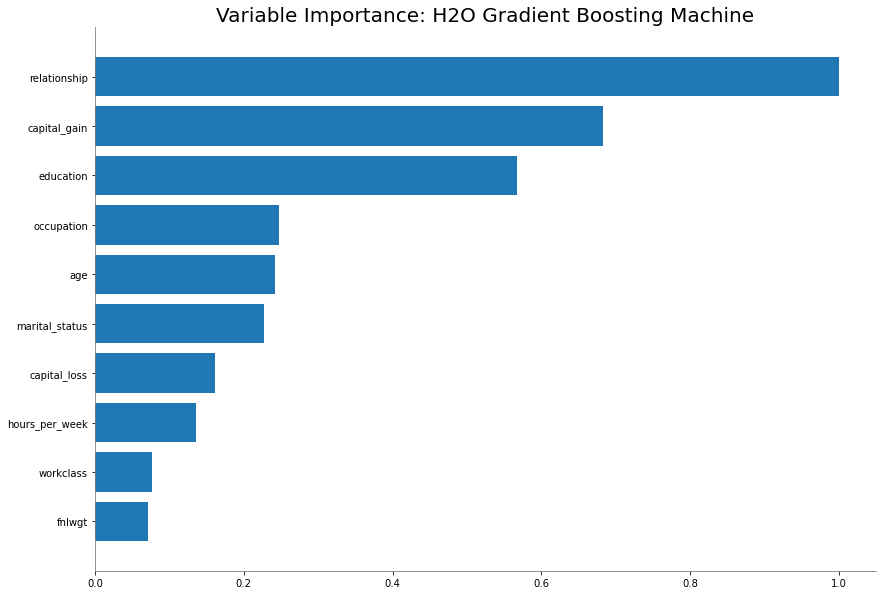

<Figure size 432x288 with 0 Axes>

In [43]:
best_model.varimp_plot()

### Explain

10-20 18:39:08.236 172.17.0.2:54321      22766  4648757-69  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_14_sid_88b4 (rows py_9_sid_88b4 [26 53 59 67 82 96 103 225 270 274 296 351 412 421 435 561 568 656 671 708 721 755 756 760 761 789 842 888 912 914 942 951 955 959 983 995 1004 1074 1129 1133 1165 1264 1286 1292 1332 1352 1355 1405 1412 1414 1423 1457 1494 1506 1542 1594 1640 1688 1716 1758 1787 1788 1811 1921 1964 1969 1983 2017 2060 2092 2106 2123 2149 2168 2183 2198 2230 2235 2256 2259 2293 2306 2308 2444 2454 2491 2499 2507 2596 2641 2707 2709 2711 2715 2751 2754 2805 2843 2896 2915 2922 2959 2964 2973 2977 3050 3098 3107 3108 3143 3155 3162 3181 3182 3218 3229 3231 3320 3333 3358 3383 3441 3459 3513 3561 3603 3623 3678 3823 3836 3874 3876 4012 4076 4133 4141 4151 4161 4221 4237 4241 4242 4243 4285 4302 4343 4350 4372 4373 4386 4388 4409 4454 4523 4527 4548 4552 4566 4586 4620 4706 4719 4746 4792 4824 4859 4866 4982 4984 4989 5002 5067 5242 5262 5270 5290 5302 5333 5

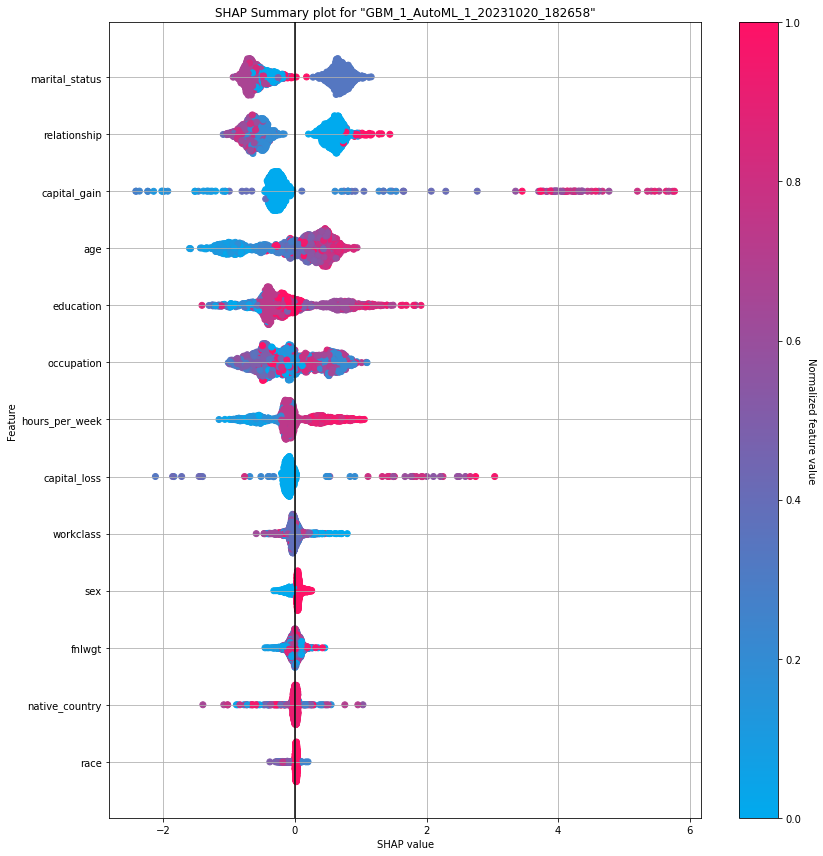

In [49]:
best_model.shap_summary_plot(train_hdf)

### Inference

In [75]:
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", DoubleType(), True),
    StructField("education", StringType(), True),
    StructField("education_num", IntegerType(), True),
    StructField("marital_status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital_gain", DoubleType(), True),
    StructField("capital_loss", DoubleType(), True),
    StructField("hours_per_week", DoubleType(), True),
    StructField("native_country", StringType(), True),
    StructField("income_level", StringType(), True),
])

test_df = (
        spark.read
        .format('csv')
        .option('header', 'true')
        .option('delimiter', ',')
        .schema(schema)
        .load(test_path)
        .withColumn('label', when(col('income_level').contains('>50K'), lit(1)).otherwise(lit(0)))
        .drop('education_num', 'income_level')
        .withColumn('workclass', when(col('workclass') == ' ?', lit('NA')).otherwise(col('workclass')))
        .withColumn('occupation', when(col('occupation') == ' ?', lit('NA')).otherwise(col('occupation')))
        .withColumn('native_country', when(col('native_country') == ' ?', lit('NA')).otherwise(col('native_country')))
    )

test_hdf = hc.asH2OFrame(test_df)
test_hdf['workclass'] = test_hdf['workclass'].asfactor()
test_hdf['education'] = test_hdf['education'].asfactor()
test_hdf['marital_status'] = test_hdf['marital_status'].asfactor()
test_hdf['occupation'] = test_hdf['occupation'].asfactor()
test_hdf['relationship'] = test_hdf['relationship'].asfactor()
test_hdf['race'] = test_hdf['race'].asfactor()
test_hdf['sex'] = test_hdf['sex'].asfactor()
test_hdf['native_country'] = test_hdf['native_country'].asfactor()

df_predict = model.predict(test_hdf)
df_predict = df_predict.cbind(test_hdf)

10-20 18:48:20.844 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
10-20 18:48:20.981 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Pushed Filters: 
10-20 18:48:20.981 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Post-Scan Filters: 
10-20 18:48:20.981 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.FileSourceStrategy: Output Data Schema: struct<age: int, workclass: string, fnlwgt: double, education: string, marital_status: string ... 12 more fields>
10-20 18:48:20.992 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.storage.memory.MemoryStore: Block broadcast_24 stored as values in memory (estimated size 176.1 KiB, free 433.9 MiB)
10-20 18:48:21.008 172.17.0.2:54321      22766  agerMaster  INFO org.apach

10-20 18:48:29.780 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor (tmp= py_62_sid_88b4 (cols_py py_61_sid_88b4 'label'))), session_id=_sid_88b4}
10-20 18:48:29.790 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_62_sid_88b4), session_id=_sid_88b4}


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

10-20 18:48:29.844 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_63_sid_88b4 (rows py_61_sid_88b4 0)), session_id=_sid_88b4}
10-20 18:48:29.863 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /4/Predictions/models/GBM_1_AutoML_1_20231020_182658/frames/py_63_sid_88b4, parms: {predict_contributions_output_format=Original, compare_abs=False, predict_contributions=True}
10-20 18:48:30.089 172.17.0.2:54321      22766  4648757-64  INFO water.default: GET /3/Frames/contributions__baec_GBM_1_AutoML_1_20231020_182658_on_py_63_sid_88b4, parms: {column_count=-1, column_offset=0, row_offset=0, full_column_count=-1, row_count=10}
10-20 18:48:30.127 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor contributions__baec_GBM_1_AutoML_1_20231020_182658_on_py_63_sid_88b4), session_id=_sid_88b4}
10-20 18:48:30.155 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Ra

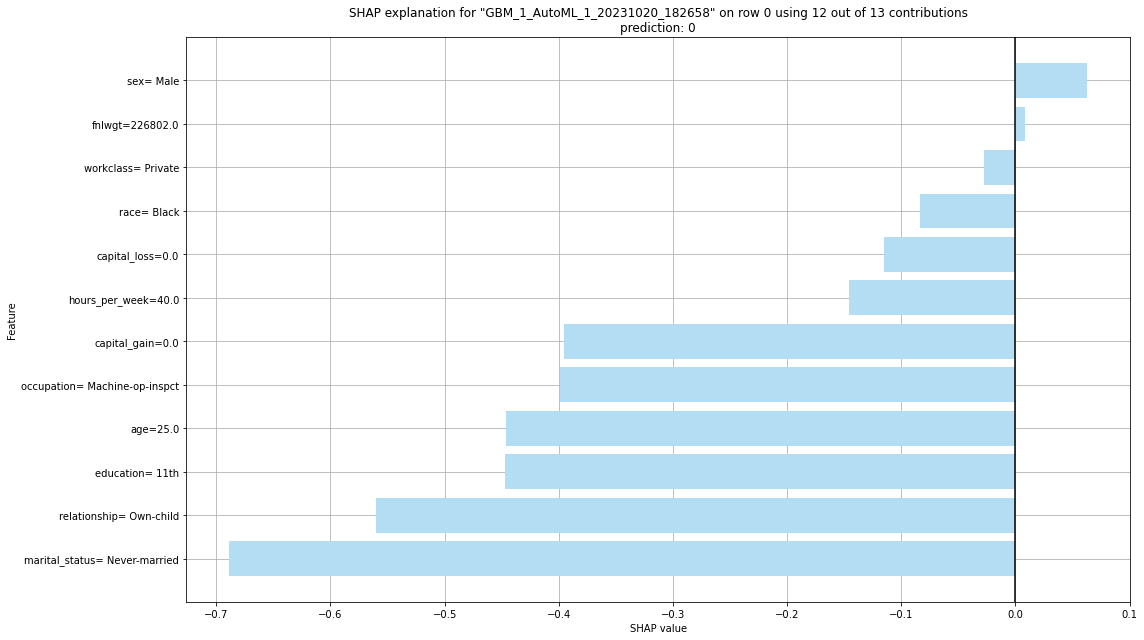

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

10-20 18:48:31.608 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor (tmp= py_83_sid_88b4 (cols_py py_61_sid_88b4 'relationship'))), session_id=_sid_88b4}
10-20 18:48:31.614 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_83_sid_88b4), session_id=_sid_88b4}
10-20 18:48:31.667 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_84_sid_88b4 (rows (cols_py py_61_sid_88b4 'relationship') 0)), session_id=_sid_88b4}
10-20 18:48:31.673 172.17.0.2:54321      22766  4648757-67  INFO water.default: GET /3/Frames/py_84_sid_88b4, parms: {column_count=-1, column_offset=0, row_offset=0, full_column_count=-1, row_count=10}
10-20 18:48:31.702 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(flatten py_84_sid_88b4), session_id=_sid_88b4}
10-20 18:48:31.706 172.17.0.2:54321      22766  4648757-67  INFO water.default: 

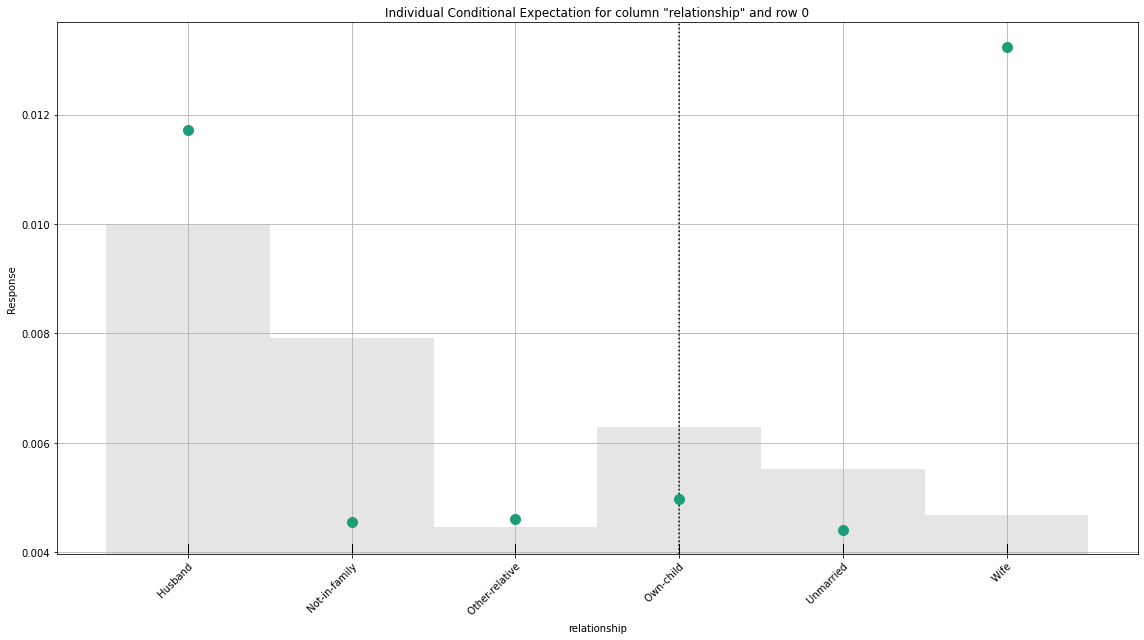



10-20 18:48:32.883 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor (tmp= py_95_sid_88b4 (cols_py py_61_sid_88b4 'capital_gain'))), session_id=_sid_88b4}
10-20 18:48:32.890 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_95_sid_88b4), session_id=_sid_88b4}
10-20 18:48:32.960 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_96_sid_88b4 (rows (cols_py py_61_sid_88b4 'capital_gain') 0)), session_id=_sid_88b4}
10-20 18:48:32.967 172.17.0.2:54321      22766  4648757-64  INFO water.default: GET /3/Frames/py_96_sid_88b4, parms: {column_count=-1, column_offset=0, row_offset=0, full_column_count=-1, row_count=10}
10-20 18:48:32.999 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(flatten py_96_sid_88b4), session_id=_sid_88b4}
10-20 18:48:33.003 172.17.0.2:54321      22766  4648757-64  INFO water.default

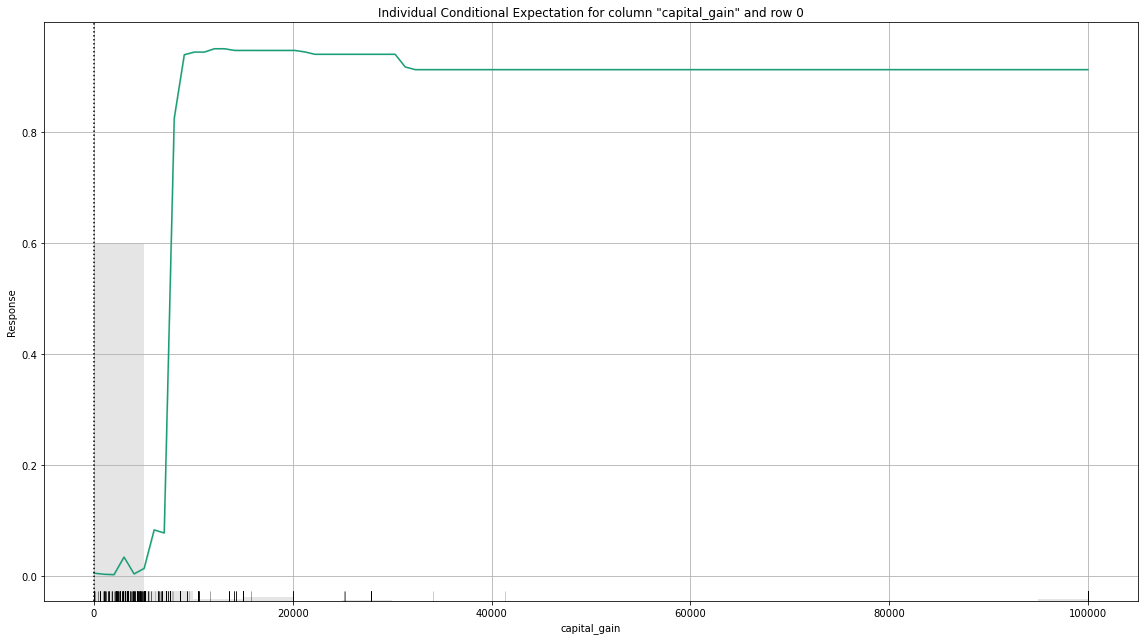



10-20 18:48:33.646 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor (tmp= py_98_sid_88b4 (cols_py py_61_sid_88b4 'education'))), session_id=_sid_88b4}
10-20 18:48:33.650 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_98_sid_88b4), session_id=_sid_88b4}
10-20 18:48:33.707 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_99_sid_88b4 (rows (cols_py py_61_sid_88b4 'education') 0)), session_id=_sid_88b4}
10-20 18:48:33.713 172.17.0.2:54321      22766  4648757-67  INFO water.default: GET /3/Frames/py_99_sid_88b4, parms: {column_count=-1, column_offset=0, row_offset=0, full_column_count=-1, row_count=10}
10-20 18:48:33.744 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(flatten py_99_sid_88b4), session_id=_sid_88b4}
10-20 18:48:33.749 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST

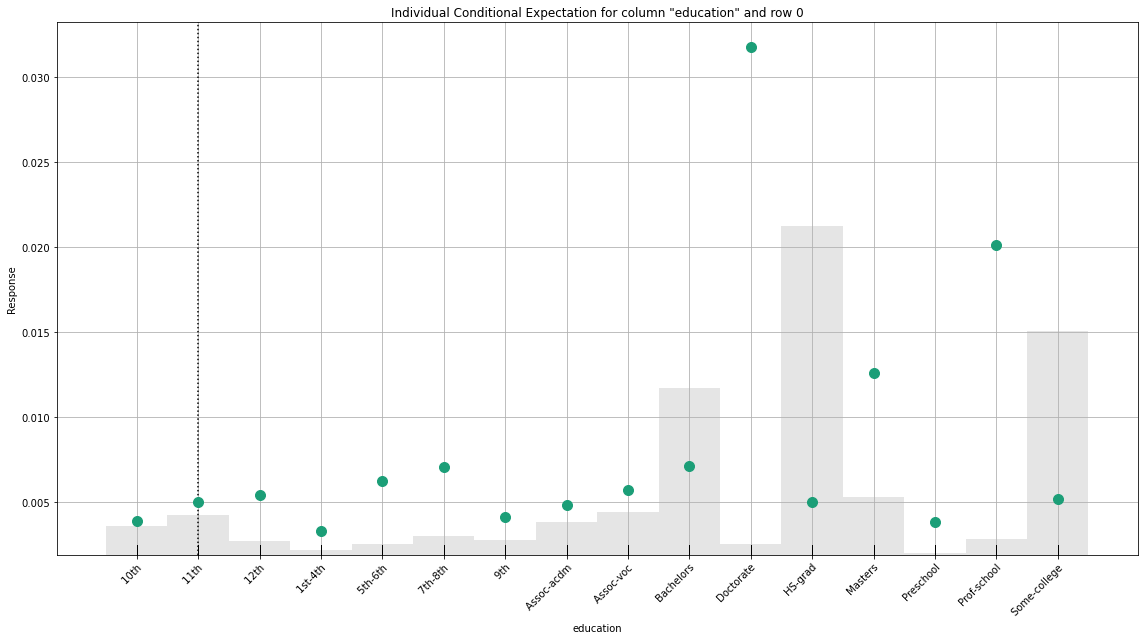



10-20 18:48:34.904 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor (tmp= py_110_sid_88b4 (cols_py py_61_sid_88b4 'occupation'))), session_id=_sid_88b4}
10-20 18:48:34.908 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_110_sid_88b4), session_id=_sid_88b4}
10-20 18:48:34.962 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_111_sid_88b4 (rows (cols_py py_61_sid_88b4 'occupation') 0)), session_id=_sid_88b4}
10-20 18:48:34.969 172.17.0.2:54321      22766  4648757-67  INFO water.default: GET /3/Frames/py_111_sid_88b4, parms: {column_count=-1, column_offset=0, row_offset=0, full_column_count=-1, row_count=10}
10-20 18:48:35.005 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(flatten py_111_sid_88b4), session_id=_sid_88b4}
10-20 18:48:35.009 172.17.0.2:54321      22766  4648757-67  INFO water.defaul

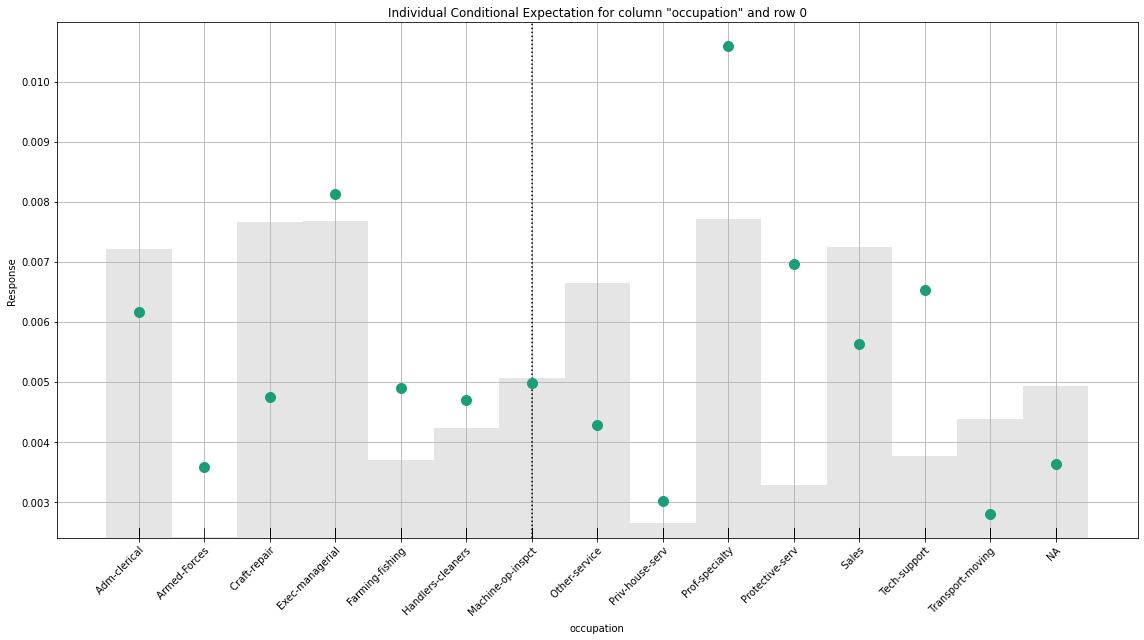



10-20 18:48:36.163 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(is.factor (tmp= py_122_sid_88b4 (cols_py py_61_sid_88b4 'age'))), session_id=_sid_88b4}
10-20 18:48:36.168 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Rapids, parms: {ast=(rm py_122_sid_88b4), session_id=_sid_88b4}
10-20 18:48:36.231 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(tmp= py_123_sid_88b4 (rows (cols_py py_61_sid_88b4 'age') 0)), session_id=_sid_88b4}
10-20 18:48:36.237 172.17.0.2:54321      22766  4648757-67  INFO water.default: GET /3/Frames/py_123_sid_88b4, parms: {column_count=-1, column_offset=0, row_offset=0, full_column_count=-1, row_count=10}
10-20 18:48:36.270 172.17.0.2:54321      22766  4648757-64  INFO water.default: POST /99/Rapids, parms: {ast=(flatten py_123_sid_88b4), session_id=_sid_88b4}
10-20 18:48:36.274 172.17.0.2:54321      22766  4648757-67  INFO water.default: POST /99/Ra

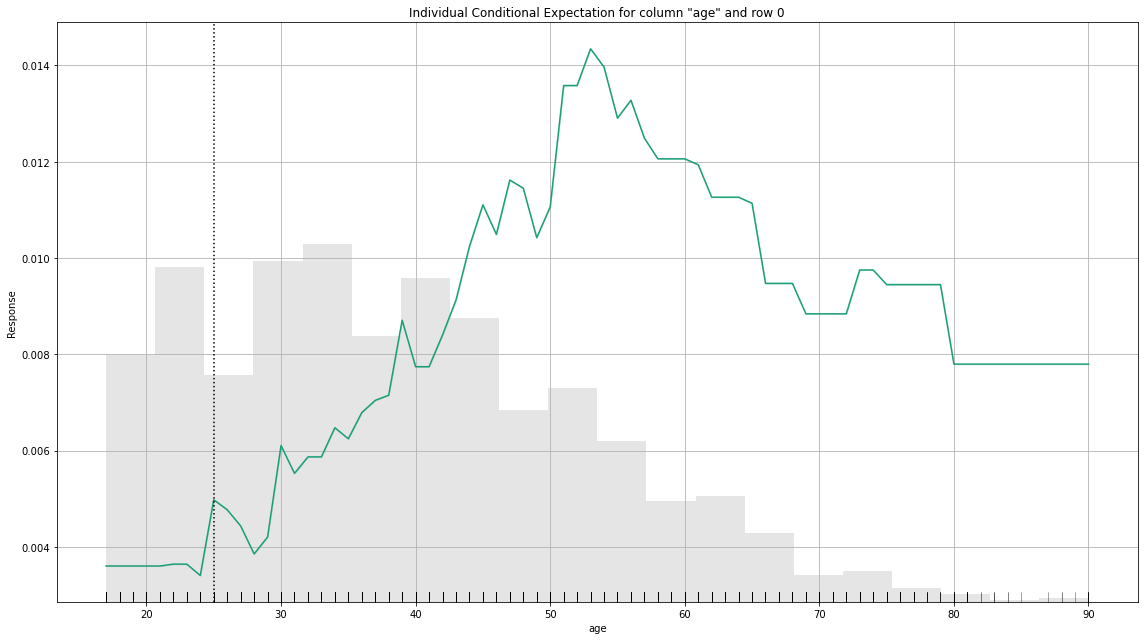

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

In [77]:
best_model.explain_row(df_predict, row_index=0)

### Saving output and model

In [82]:
(
    hc.asSparkFrame(df_predict).drop('label')
    .write.parquet(pred_path, mode='overwrite')
)

10-20 18:50:09.142 172.17.0.2:54321      22766  4648757-67  INFO water.default: GET /3/Frames/py_61_sid_88b4/light, parms: {full_column_count=0, row_count=0}
10-20 18:50:09.144 172.17.0.2:54321      22766    Thread-4  INFO ai.h2o.sparkling.H2OFrame: H2O node http://172.17.0.2:54321/3/Frames/py_61_sid_88b4/light?row_count=0&full_column_count=0 successfully responded for the GET.
10-20 18:50:09.150 172.17.0.2:54321      22766    Thread-4  INFO ai.h2o.sparkling.backend.utils.RestApiUtils: H2O node http://172.17.0.2:54321/3/Cloud successfully responded for the GET.
10-20 18:50:09.154 172.17.0.2:54321      22766  4648757-67  INFO water.default: GET /3/FrameChunks/py_61_sid_88b4, parms: {}
10-20 18:50:09.156 172.17.0.2:54321      22766    Thread-4  INFO ai.h2o.sparkling.H2OFrame: H2O node http://172.17.0.2:54321/3/FrameChunks/py_61_sid_88b4 successfully responded for the GET.
10-20 18:50:09.320 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.parquet.P

10-20 18:50:10.082 172.17.0.2:54321      22766  0 (TID 20)  INFO org.apache.parquet.hadoop.InternalParquetRecordWriter: Flushing mem columnStore to file. allocated memory: 1355376
10-20 18:50:10.322 172.17.0.2:54321      22766  0 (TID 20)  INFO org.apache.spark.mapred.SparkHadoopMapRedUtil: attempt_202310201850094284408001017747594_0020_m_000000_20: Committed
10-20 18:50:10.334 172.17.0.2:54321      22766  0 (TID 20)  INFO org.apache.spark.executor.Executor: Finished task 0.0 in stage 20.0 (TID 20). 2396 bytes result sent to driver
10-20 18:50:10.335 172.17.0.2:54321      22766  t-getter-0  INFO org.apache.spark.scheduler.TaskSetManager: Finished task 0.0 in stage 20.0 (TID 20) in 884 ms on 95675304fa2d (executor driver) (1/1)
10-20 18:50:10.335 172.17.0.2:54321      22766  t-getter-0  INFO org.apache.spark.scheduler.TaskSchedulerImpl: Removed TaskSet 20.0, whose tasks have all completed, from pool 
10-20 18:50:10.335 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.sched

In [83]:
spark.read.load(pred_path).limit(10).toPandas()

10-20 18:50:20.282 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.sql.execution.datasources.InMemoryFileIndex: It took 4 ms to list leaf files for 1 paths.
10-20 18:50:20.355 172.17.0.2:54321      22766  agerMaster  INFO org.apache.spark.storage.BlockManagerInfo: Removed broadcast_29_piece0 on 95675304fa2d:41565 in memory (size: 70.0 KiB, free: 434.4 MiB)
10-20 18:50:20.374 172.17.0.2:54321      22766    Thread-4  INFO org.apache.spark.SparkContext: Starting job: load at NativeMethodAccessorImpl.java:0
10-20 18:50:20.375 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: Got job 20 (load at NativeMethodAccessorImpl.java:0) with 1 output partitions
10-20 18:50:20.375 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: Final stage: ResultStage 21 (load at NativeMethodAccessorImpl.java:0)
10-20 18:50:20.375 172.17.0.2:54321      22766  event-loop  INFO org.apache.spark.scheduler.DAGScheduler: Parents of

,predict,p0,p1,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,0.995022,0.004978,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,0,0.819929,0.180071,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,1,0.577573,0.422427,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,1,0.012681,0.987319,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,0,0.998556,0.001444,18,NA,103497,Some-college,Never-married,NA,Own-child,White,Female,0,0,30,United-States
5,0,0.994051,0.005949,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States
6,0,0.997010,0.002990,29,NA,227026,HS-grad,Never-married,NA,Unmarried,Black,Male,0,0,40,United-States
7,1,0.090285,0.909715,63,Self-emp-not-inc,104626,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States
8,0,0.994831,0.005169,24,Private,369667,Some-college,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States
9,0,0.944497,0.055503,55,Private,104996,7th-8th,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States


In [89]:
best_model.model_id = 'automl_leader'
h2o.save_model(best_model, model_path, force=True)

10-20 18:52:23.333 172.17.0.2:54321      22766  4648757-70  INFO water.default: POST /99/Rapids, parms: {ast=(rename 'GBM_1_AutoML_1_20231020_182658' 'automl_leader'), session_id=_sid_88b4}
10-20 18:52:23.354 172.17.0.2:54321      22766  4648757-65  INFO water.default: GET /99/Models.bin/automl_leader, parms: {export_cross_validation_predictions=False, force=True, dir=outputs/income_automl_h2o/automl_leader}


'/home/jovyan/notebooks/outputs/income_automl_h2o/automl_leader'

In [92]:
model = h2o.load_model(model_path + '/automl_leader')

10-20 18:52:42.014 172.17.0.2:54321      22766  4648757-70  INFO water.default: POST /99/Models.bin/, parms: {dir=outputs/income_automl_h2o/automl_leader}
10-20 18:52:42.100 172.17.0.2:54321      22766  agerMaster  INFO org.apache.spark.storage.BlockManagerInfo: Removed broadcast_31_piece0 on 95675304fa2d:41565 in memory (size: 32.3 KiB, free: 434.4 MiB)
10-20 18:52:42.118 172.17.0.2:54321      22766  4648757-69  INFO water.default: GET /3/Models/automl_leader, parms: {}
10-20 18:52:42.138 172.17.0.2:54321      22766  agerMaster  INFO org.apache.spark.storage.BlockManagerInfo: Removed broadcast_32_piece0 on 95675304fa2d:41565 in memory (size: 8.5 KiB, free: 434.4 MiB)
10-20 18:52:42.176 172.17.0.2:54321      22766  agerMaster  INFO org.apache.spark.storage.BlockManagerInfo: Removed broadcast_30_piece0 on 95675304fa2d:41565 in memory (size: 30.1 KiB, free: 434.4 MiB)


In [93]:
model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: automl_leader


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    72                 72                          116356                 15           15           15            39            191           120.194

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07499008289803473
RMSE: 0.2738431720858395
LogLoss: 0.23889571105783058
Mean Per-Class Error: 0.14244552377780226
AUC: 0.9514336309556976
AUCPR: 0.8749514407177378
Gini: 0.9028672619113951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3881431172229534
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      22665  2055  0.0831   (2055.0/24720.0)
1      1582   6259  0.2018   (1582.0/7841.0)
Total  24247  8314  0.1117   (3637.0/32561.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.388143     0.774868  204
max f2                       0.190488     0.844843  284
max f0point5                 0.595714     0.809089  134
max accuracy                 0.457894     0.892356  181
max precision                0.99468      1         0
max recall                   0.0101622    1         386
max specificity              0.99468      1         0
max absolute_mcc             0.419953     0.701931  192
max min_per_class_accuracy   0.294618     0.8717    241
max mean_per_class_accuracy  0.248702     0.875379  260
max tns                      0.99468      24720     0
max fns                      0.99468      7775      0
max fps                      0.00121637   24720     399
max tps                      0.0101622    7841      386
max tnr                      0.99468      1         0
max fnr                      0.99468      0.991583  0
max fpr                      0.00121637   1         399
max tpr                      0.0101622    1         386

Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.08 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010012                    0.990948           4.15266     4.15266            1                0.992823    1                           0.992823            0.0415763       0.0415763                  315.266   315.266            0.0415763
2        0.020024                    0.987361           4.15266     4.15266            1                0.989244    1                           0.991034            0.0415763       0.0831527                  315.266   315.266            0.0831527
3        0.0300052                   0.982672           4.15266     4.15266            1                0.9852      1                           0.989093            0.0414488       0.124601                   315.266   315.266            0.124601
4        0.0400172                   0.975001           4.15266     4.15266            1                0.979344    1                           0.986654            0.0415763       0.166178                   315.266   315.266            0.166178
5        0.0500292                   0.957482           4.13992     4.15011            0.996933         0.968104    0.999386         